# Overview
In this assignment, you will perform regression analysis on the Citi Bike trips dataset. You
will fit several linear regression models to predict the duration of Citi Bike trips based on
various feature variables.

In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import piecewise_regression as pwr

1. You can find the dataset at: info615/data/citibike_sample_boros.csv. This dataset
has been augmented to include start_boro and end_boro columns. Read this CSV into a
DataFrame called df and view the first few rows.

In [2]:
df = pd.read_csv("/Users/markos98/info615/data/citibike_sample_boros.csv")

In [20]:
df.head()

,starttime,hour,day,usertype,gender,age,tripduration_minutes,distance_miles,start_boro,end_boro,distance_category
0,2020-10-27 16:51:37.994,16,Tuesday,Subscriber,male,37,21.816667,3.047236,Manhattan,Manhattan,long
1,2020-10-09 19:46:12.616,19,Friday,Subscriber,male,24,25.883333,1.418907,Manhattan,Manhattan,medium
2,2020-10-10 15:19:17.455,15,Saturday,Subscriber,female,36,7.283333,0.502512,Brooklyn,Brooklyn,medium
3,2020-10-28 01:30:42.644,1,Wednesday,Subscriber,male,31,24.833333,0.633161,Brooklyn,Brooklyn,medium
4,2020-10-11 16:48:46.773,16,Sunday,Subscriber,male,42,19.633333,1.002208,Brooklyn,Brooklyn,medium


2. It’s a good practice to start with a simple linear regression model before doing anything
more complex. We can use it as a baseline to benchmark the performance of future models.

a) Fit a simple linear regression model called model1 of the form y ∼ X, where y is trip
duration in minutes and X is distance in miles

In [3]:
# Define the regression formula
formula = "tripduration_minutes ~ distance_miles"

# Fitting a linear regression using OLS
model1 = smf.ols(formula, data=df).fit()

b) View a summary of model1.

In [4]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     tripduration_minutes   R-squared:                       0.209
Model:                              OLS   Adj. R-squared:                  0.209
Method:                   Least Squares   F-statistic:                 1.320e+05
Date:                  Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                          13:27:36   Log-Likelihood:            -1.9913e+06
No. Observations:                500000   AIC:                         3.983e+06
Df Residuals:                    499998   BIC:                         3.983e+06
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          9.0094      0.029    307.067      0.000       8.952       9.067
distance_miles     6.0801      0.017    363.311      0.000       6.047       6.113
==============================================================================
Omnibus:                   463117.618   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21435570.106
Skew:                           4.473   Prob(JB):                         0.00
Kurtosis:                      33.804   Cond. No.                         3.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c) What is R2 for model1?

- 0.209

d) What is the Sum of Squared Residuals for model1? (Hint: you can access this with:
model.ssr).

In [5]:
model1.ssr

np.float64(84267381.65706983)

- 84,267,381.66

e) Interpret the model’s coefficients. What is the intercept, and what is the slope of
the regression line? What do this intercept and slope suggest about the relationship
between y and X, under this model?

- Intercept = 9.0094
- Slope = 6.0801
- The intercept is where the plot starts when x is 0, so this line of best fit starts at 9.0094 minutes.
- The slope indicates that for every additional mile, the length increases by 6.08 minutes. 

f) Plot your regression line on top of a scatter plot of the actual data, with trip duration
on the y-axis and distance on the x-axis. Do you see any concerning patterns?

NameError: name 'plt' is not defined

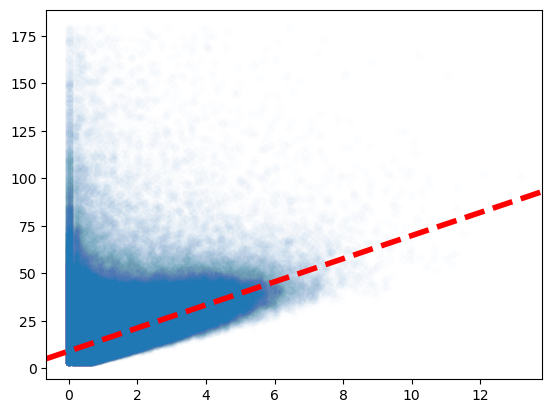

In [6]:
ax = sns.scatterplot(y=model1.model.endog,
                     x=model1.model.exog[:,1], alpha=0.01)
sm.graphics.abline_plot(model_results=model1, color='red',
                        linewidth=4, linestyle='--', ax=ax)
plt.title("Regression Plot", fontweight="bold")
plt.xlabel(f"{model.model.exog_names[1]} (X)")
plt.ylabel(f"{model.model.endog_names[1]} (Y)")

- It doesn't look normally distributed, since many data points pool under 1 mile while many outliers persist the distribution isn't uniform.

g) Plot your model’s residuals as a histogram. Do the residuals look approximately normally distributed around zero?

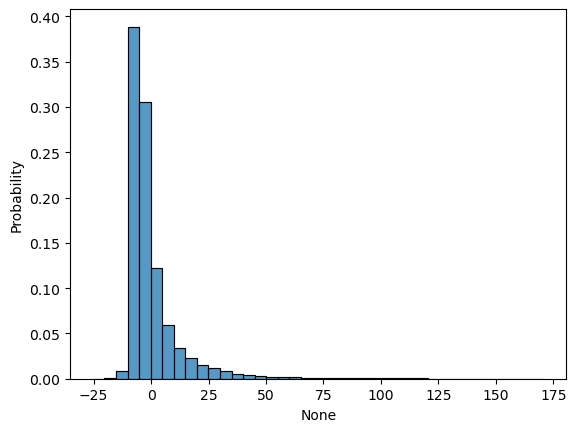

In [7]:
sns.histplot(x=model1.resid,
             stat='probability',
             binwidth=5);

- No, it appears rightly skewed.

h) Plot your model’s residuals as a scatter plot, with the residuals on the y-axis and actual trip distance on the x-axis. Do the residuals look homoscedastic or heteroscedastic?

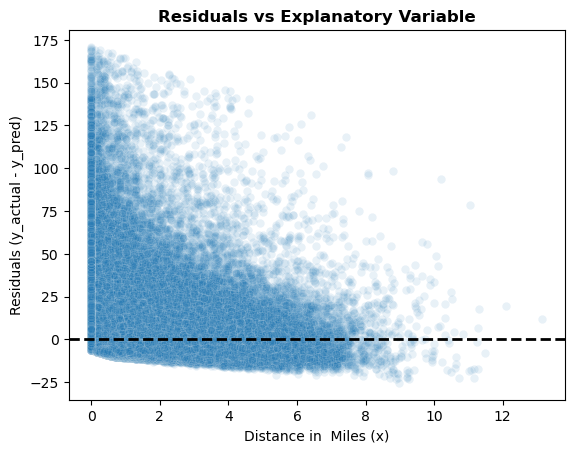

In [8]:
ax=sns.scatterplot(
    x=model1.model.exog[:,1],
    y=model1.resid,
    alpha=0.1
)
ax.axhline(0, color='black', lw=2,
           linestyle='--');
ax.set_title('Residuals vs Explanatory Variable',
             fontweight="bold")
ax.set_xlabel('Distance in  Miles (x)')
ax.set_ylabel('Residuals (y_actual - y_pred)');

- Heteroscedastic. As in the histogram it isn't normally distributed, plus the errors here aren't uniform either. 

i) Considering your results from 2g) and 2h), does this baseline model satisfy or violate the assumptions that linear regression makes about the residuals?

- It violates the assumption that each subpopulation is normally distributed. 

3. We observe that our simple linear regression model tends to have larger errors as distance
gets smaller. This is due to how distance is defined in our data (origin-to-destination distance
rather than actual distance traveled). So, we might want to think about trips having small
A-to-B distance as ‘round trips’, and model these trips as a separate category. Rather
than defining an arbitrary cutoff, let’s use Piecewise Regression to detect breakpoints in the
relationship between duration and distance.

a) Install the piecewise-regression library with pip install piecewise-regression.

b) Fit a Piecewise Regression model of the form y ∼ X, again with y = duration and X
= distance, and with n_breakpoints = 2. Piecewise Regression can take a long time
on large datasets, so only use a sample 10,000 trips to fit the model.

In [9]:
sample = df.sample(10000)

x = sample['distance_miles'].values
y = sample['tripduration_minutes'].values

pw_reg = pwr.Fit(x, y, n_breakpoints=2)

c) Plot the resulting regression line from the Piecewise Regression.

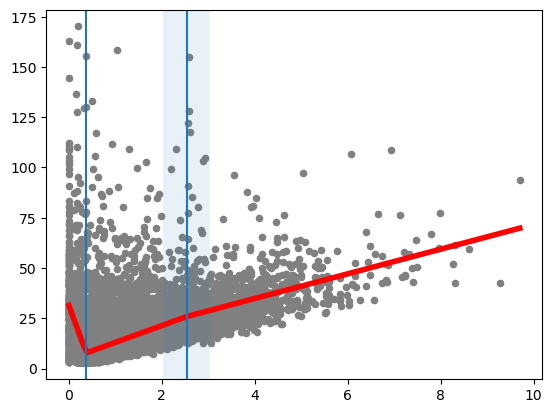

In [10]:
pw_reg.plot_data(color="grey", s=20)
pw_reg.plot_fit(color="red", linewidth=4)
pw_reg.plot_breakpoints()
pw_reg.plot_breakpoint_confidence_intervals()

d) What are the breakpoints detected by the Piecewise Regression?

In [11]:
pw_reg.summary()


                    Breakpoint Regression Results                     
No. Observations                    10000
No. Model Parameters                    6
Degrees of Freedom                   9994
Res. Sum of Squares           1.38392e+06
Total Sum of Squares          2.04308e+06
R Squared                        0.322630
Adjusted R Squared               0.322224
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const                31.4108        0.598       52.532           0.0       30.239       32.583
alpha1              -63.4418         2.54      -25.012     5.65e-134      -68.414       -58.47
beta1                71.8151         2.55       28.185             -       66.821        76.81
beta2               -2.23879        0.406      -5.5165             -      -3.0343      -1.4433
breakpoint1      

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                    10000\nNo. Model Parameters                    6\nDegrees of Freedom                   9994\nRes. Sum of Squares           1.38392e+06\nTotal Sum of Squares          2.04308e+06\nR Squared                        0.322630\nAdjusted R Squared               0.322224\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst                31.4108        0.598       52.532           0.0       30.

- breakpoint1 = 0.362768
- breakpoint2 = 2.22152

e) These two breakpoints create three regression segments. How do the three regression
segments compare to each other? Are there any major changes in slope?

- The three alphas are: -68.4829, 8.77731, 6.1071.
- Alpha 3 is the nearly identical to the original slope, whereas the two others changed majorly.

4. Now that we have calculated statistically significant break points, we can use this information to augment our model.

a) Using the breakpoints that you calculated in Problem 3, create a new column in df
called distance_category. This new column should contain ‘round trip’ for trips with
distance less than Breakpoint 1, ‘medium’ for trips with distance between Breakpoint
1 and Breakpoint 2, and ‘long’ for trips with distance greater than Breakpoint 2.

In [14]:
estimates = pw_reg.get_results()['estimates']

breakpoints = [estimates[i]['estimate'] for i in estimates if 'breakpoint' in i]

In [15]:
def create_distance_categories(x, breakpoints):
    if x < breakpoints[0]:
        return "round_trip"
    elif x >= breakpoints[0] and x < breakpoints[1]:
        return "medium"
    elif x >= breakpoints[1]:
        return "long"

df['distance_category'] = df['distance_miles'].apply(lambda x: create_distance_categories(x, breakpoints))

df[['distance_miles', 'distance_category']]

,distance_miles,distance_category
0,3.047236,long
1,1.418907,medium
2,0.502512,medium
3,0.633161,medium
4,1.002208,medium
...,...,...
499995,0.000000,round_trip
499996,0.480442,medium
499997,1.463696,medium
499998,2.151782,medium


b) Fit a multiple linear regression (MLR) model called model2 of the form y ∼ X1 + X2,
where y is trip duration in minutes, X1 is A-to-B distance in miles, and X2 is the
categorical variable distance_category that you just created.

In [16]:
formula = "tripduration_minutes ~ distance_miles + C(distance_category)"

model2 = smf.ols(formula, data=df).fit()

c) View a summary of model2. What is the R2?

In [17]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     tripduration_minutes   R-squared:                       0.269
Model:                              OLS   Adj. R-squared:                  0.269
Method:                   Least Squares   F-statistic:                 6.136e+04
Date:                  Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                          13:31:38   Log-Likelihood:            -1.9715e+06
No. Observations:                500000   AIC:                         3.943e+06
Df Residuals:                    499996   BIC:                         3.943e+06
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              6.2348      0.114     54.665      0.000       6.011       6.458
C(distance_category)[T.medium]        -0.3134      0.087     -3.582      0.000      -0.485      -0.142
C(distance_category)[T.round_trip]    12.0406      0.122     98.989      0.000      11.802      12.279
distance_miles                         7.3249      0.029    253.590      0.000       7.268       7.381
==============================================================================
Omnibus:                   453797.963   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22074772.047
Skew:                           4.301   Prob(JB):                         0.00
Kurtosis:                      34.394   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- .273

d) Interpret model2’s coefficients. What is the change in duration associated with a trip
being a ‘round trip’, versus a ‘long trip’ ?

- 1 additional mile is associated with an increase in duration of 7.0726 minutes.
- If the trip is a round trip, add an additional 11.64 minutes.
- If the trip is a medium trip, subtract 1.14 minutes.
- While the middle slope is pretty similar to our old slope of 6, the others are quite different and can help to can slice our populations more normally now.

e) Fit another multiple linear regression (MLR) model called model3 of the form y ∼
X1 ∗ X2, where y is trip duration in minutes, X1 is A-to-B distance in miles, X2 is
distance_category. In this formulation, we are including an interaction term between
X1 and X2 by using the ∗ operator.

In [52]:
estimates = pw_reg.get_results()['estimates']

breakpoints = [estimates[i]['estimate'] for i in estimates if 'breakpoint' in i]

formula = "tripduration_minutes ~ distance_miles * C(distance_category)"

model3 = smf.ols(formula, data=df).fit()

f) View and interpret the results of model3. Does adding an interaction term between
X1 and X2 as you did in 4e) improve the model, compared to model2 which had no
interaction term? Why?

In [53]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     tripduration_minutes   R-squared:                       0.324
Model:                              OLS   Adj. R-squared:                  0.324
Method:                   Least Squares   F-statistic:                 4.784e+04
Date:                  Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                          13:47:42   Log-Likelihood:            -1.9521e+06
No. Observations:                500000   AIC:                         3.904e+06
Df Residuals:                    499994   BIC:                         3.904e+06
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             9.5501      0.173     55.207      0.000       9.211       9.889
C(distance_category)[T.medium]                       -4.9783      0.179    -27.868      0.000      -5.328      -4.628
C(distance_category)[T.round_trip]                   21.9705      0.193    114.065      0.000      21.593      22.348
distance_miles                                        6.3971      0.047    137.235      0.000       6.306       6.488
distance_miles:C(distance_category)[T.medium]         2.0984      0.058     36.086      0.000       1.984       2.212
distance_miles:C(distance_category)[T.round_trip]   -70.6258      0.366   -192.715      0.000     -71.344     -69.907
==============================================================================
Omnibus:                   471354.070   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26474796.969
Skew:                           4.522   Prob(JB):                         0.00
Kurtosis:                      37.482   Cond. No.                         50.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- It improved the r-squared. The additive formula assumes that the effect of y on x1 is the same in each category of x2, whereas the interaction formula assumes that there is effect of y on x1 is different in each x2 category. Since this model is more accurate, we have reason to believe that the relationship between trip distance and trip duration change based on which category they belong to. 

5. In this problem, you will attempt to improve on the models that we’ve developed so far.

a) Choose or create at least two additional features from df and incorporate them into a
new model called model4. Fit model4 and view the results.

In [57]:
formula = "distance_miles ~ tripduration_minutes * usertype + age"

model4 = smf.ols(formula, data=df).fit()

model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         distance_miles   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                 4.125e+04
Date:                Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:50:16   Log-Likelihood:            -6.8449e+05
No. Observations:              500000   AIC:                         1.369e+06
Df Residuals:                  499995   BIC:                         1.369e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                       1.1929      0.006    200.641      0.000       1.181       1.205
usertype[T.Subscriber]                         -0.4774      0.005    -97.579      0.000      -0.487      -0.468
tripduration_minutes                            0.0184      0.000    129.130      0.000       0.018       0.019
tripduration_minutes:usertype[T.Subscriber]     0.0295      0.000    155.382      0.000       0.029       0.030
age                                            -0.0034      0.000    -31.094      0.000      -0.004      -0.003
==============================================================================
Omnibus:                    68243.052   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           703124.140
Skew:                           0.302   Prob(JB):                         0.00
Kurtosis:                       8.778   Cond. No.                         235.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

b) Is there any improvement in the goodness of fit or normality of the residuals compared
to model3? If you are happy with the improvement, move on to 5c). Otherwise,
reconsider your choices in 5a).

- Age is not as good as a predictor than the distance_category we made.

In [59]:
formula = "distance_miles ~ tripduration_minutes * distance_category * usertype"

model4 = smf.ols(formula, data=df).fit()

model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         distance_miles   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                 1.433e+05
Date:                Sat, 05 Apr 2025   Prob (F-statistic):               0.00
Time:                        13:50:57   Log-Likelihood:            -3.9988e+05
No. Observations:              500000   AIC:                         7.998e+05
Df Residuals:                  499988   BIC:                         7.999e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================
                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       2.6092      0.009    296.798      0.000       2.592       2.626
distance_category[T.medium]                                                    -1.5576      0.009   -168.535      0.000      -1.576      -1.539
distance_category[T.round_trip]                                                -2.4458      0.011   -221.052      0.000      -2.467      -2.424
usertype[T.Subscriber]                                                         -0.4228      0.011    -36.958      0.000      -0.445      -0.400
distance_category[T.medium]:usertype[T.Subscriber]                              0.1126      0.012      9.453      0.000       0.089       0.136
distance_category[T.round_trip]:usertype[T.Subscriber]                          0.5166      0.014     37.623      0.000       0.490       0.544
tripduration_minutes                                                            0.0266      0.000    122.086      0.000       0.026       0.027
tripduration_minutes:distance_category[T.medium]                               -0.0160      0.000    -64.124      0.000      -0.016      -0.015
tripduration_minutes:distance_category[T.round_trip]                           -0.0277      0.000   -103.753      0.000      -0.028      -0.027
tripduration_minutes:usertype[T.Subscriber]                                     0.0184      0.000     59.099      0.000       0.018       0.019
tripduration_minutes:distance_category[T.medium]:usertype[T.Subscriber]         0.0002      0.000      0.479      0.632      -0.001       0.001
tripduration_minutes:distance_category[T.round_trip]:usertype[T.Subscriber]    -0.0207      0.000    -54.706      0.000      -0.021      -0.020
==============================================================================
Omnibus:                    90748.565   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1090061.481
Skew:                           0.521   Prob(JB):                         0.00
Kurtosis:                      10.158   Cond. No.                         994.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c) Once you are happy with your model, explain your rationale for choosing the additional
variables that you did, and explain how and why you chose to incorporate them (i.e.
with or without interaction).

- Compounding distance_category with usertype makes our r-squared .759, pointing to the fact that the type of user correlates strongly with what kind of trip they are on.

d) There are many potential factors which could influence the duration of a bike-share
trip. Suggest at least two additional factors not included in our dataset that you think
would improve our model’s predictive power and explain why.

- Weather and time of year. Many people are fairweather cyclists and won't rent a bike if it's cold or rainy. It would also be interesting to see how well non-subscriber use correlates with tourist seasons. 